In [2]:
import csv
import cv2
import matplotlib.pyplot as plt
from plotnine import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
from PIL import Image
import torchvision.models as models
%matplotlib inline
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [228]:
class MuraBodyDataset(torch.utils.data.Dataset):
    
    def __init__(self,text_file,root_dir, transform ): #Normalize to pretrained VGGNet
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        #File with the Path
        self.name_frame = pd.read_csv(text_file,sep=",",usecols=[0],dtype = 'str')
        #File with labels
        self.label_frame = pd.read_csv(text_file,sep=",", usecols=[1])
        self.root_dir = root_dir
        self.transform = transform
                                       
    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, idx):
        #Pull image
        img_name = os.path.join(self.root_dir, self.name_frame.iloc[idx, 0])
        
        #Apply adapative threshold to highlight key features in the image   
        image = cv2.imread(img_name,0)
        image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)  
        image = Image.fromarray(image)
        image = image.convert('L')
        
        #Apply tensor transformations to images
        image = self.transform(image) 
        
        # I included labels in the train_image_path file in excel using a find("positive")
        labels = self.label_frame.iloc[idx,0] 
        
        #Formatting for labels
        labels = np.array(labels)
        labels = np.reshape(labels, (1,1))
        labels= torch.from_numpy(labels.astype('int'))

        sample = {'image': image, 'labels': labels}
        
        return sample

In [229]:
MuraTrainSet = MuraBodyDataset(text_file ='/Users/JosephVele/MURA-v1.1/Shoulder_Mura.csv',
                               root_dir = '/Users/JosephVele',
                               transform = transforms.Compose([transforms.Resize((227,227)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(
                                                              mean=[0.456],
                                                              std= [0.225])]))

MuraTrainLoader = torch.utils.data.DataLoader(MuraTrainSet,batch_size=10,shuffle=True, num_workers=0)

MuraTestSet = MuraBodyDataset(text_file ='/Users/JosephVele/MURA-v1.1/Shoulder_Mura_test.csv',
                              root_dir = '/Users/JosephVele',
                              transform = transforms.Compose([transforms.Resize((227,227)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(
                                                              mean=[0.456],
                                                              std= [0.225])]))

MuraTestLoader = torch.utils.data.DataLoader(MuraTestSet,batch_size=8,shuffle=False, num_workers=0)

In [230]:
dense_net169 = models.densenet169(pretrained=True)

/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [232]:
for param in dense_net169.features.parameters():
    param.requires_grad = False
#Adjust to grayscale = 1 channel. Requires gradient is True by default
dense_net169.features._modules['conv0']  = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
dense_net169.classifier = nn.Linear(in_features=1664, out_features=1, bias=True)
#dense_net169

#for param in dense_net169.classifier.parameters():
#    print(param.size())
    
#dense_net169.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [233]:
# Define hyper-parameters - Use Random Search 
#******************************#

learning = 0.0001  # Learning Rate 
w = 1e-1
b = [.9,999]
#******************************#

In [234]:
# 4.1 Define criterion and optimizer
#************************************#
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(dense_net169.parameters(), lr=learning, weight_decay = w)

#************************************#

# 4.2 Train the model
# 4.3 Please store and print training and validation loss&accuracy after each epoch
#********************************************#

train_losses_dense = []
test_losses_dense = []
acc_data_train_dense =[]
acc_data_test_dense=[]


def train(epoch, max_batch):
    alex_net.train()
    train_loss = 0
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    for i, sample_batched in enumerate(MuraTrainLoader,1):
        if i <max_batch:
        
            inputs = sample_batched['image']
            labels = sample_batched['labels']
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = dense_net169(inputs)
            labels = labels.view(len(sample_batched['labels']),-1)
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()
            train_loss+= loss.item()

            pred = (torch.sigmoid(outputs).data > 0.5).int()
            labels = labels.int()
            TP += ((pred == 1) & (labels == 1) ).float().sum() #True Positive Count
            TN += ((pred == 0) & (labels == 0) ).float().sum() #True Negative Count
            FP += ((pred == 1) & (labels == 0) ).float().sum() #False Positive Count
            FN += ((pred == 0) & (labels == 1) ).float().sum() #False Negative Count
        else:
            break
    
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1_score = 2 * (precision*recall)/(precision+recall)
    acc_data_train.append([TP, TN, FP, FN, accuracy, precision, recall, f1_score])
    train_loss=float(train_loss)/float(i)
    train_losses_dense.append(train_loss)
    # print statistics        
    print('Train Epoch:{}  Accuracy: {:.2f}   Average Loss: {:.2f}  Precision: {:.2f}   F1 Score: {:.2f}\n'.
          format(epoch, accuracy, train_loss, precision, f1_score))

def test(epoch):
    #Have our model in evaluation mode
    dense_net169.eval()
    #Set losses and Correct labels to zero
    test_loss = 0
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    with torch.no_grad():
        for i, sample_batched in enumerate(MuraTestLoader,1):
            inputs = sample_batched['image']
            labels = sample_batched['labels']
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = dense_net169(inputs)
            labels = labels.view(len(sample_batched['labels']),-1)
            loss = criterion(outputs.float(), labels.float())
            test_loss += loss.item()

            pred = (torch.sigmoid(outputs).data > 0.5).int()
            labels = labels.int()
            TP += ((pred == 1) & (labels == 1) ).float().sum() #True Positive Count
            TN += ((pred == 0) & (labels == 0) ).float().sum() #True Negative Count
            FP += ((pred == 1) & (labels == 0) ).float().sum() #False Positive Count
            FN += ((pred == 0) & (labels == 1) ).float().sum() #False Negative Count
            #print('TP: {}\t TN: {}\t FP: {}\t FN: {}\n'.format(TP,TN,FP,FN) )    

        accuracy = (TP + TN)/(TP + TN + FP + FN)
        precision = TP/(TP + FP)
        recall = TP/(TP + FN)
        f1_score = 2 * (precision*recall)/(precision+recall)
        acc_data_test.append([TP, TN, FP, FN, accuracy, precision, recall, f1_score])
        test_loss = float(test_loss)/float(i)
        test_losses.append(test_loss)
        # print statistics        
        print('Test  Epoch:{}  Accuracy: {:.2f}   Average Loss: {:.2f}  Precision: {:.2f}   F1 Score: {:.2f}\n'.
              format(epoch, accuracy, test_loss, precision, f1_score))


In [37]:
import random
lr= round(np.exp(random.uniform(np.log(.001), np.log(10))),4) #pull geometrically
w = round(np.exp(random.uniform(np.log(3.1e-7), np.log(3.1e-5))),10) #pull geometrically


1.9402e-06

In [236]:
print( 'Learning Rate : {}\t Weight Decay {}'.format(learning, w))
#Train + Test per epoch
for epoch in range(1,6): 
    train(epoch,40)

Learning Rate : 0.0001	 Weight Decay 0.1
Train Epoch:1  Accuracy: 0.52   Average Loss: 0.68  Precision: 0.52   F1 Score: 0.62

Train Epoch:2  Accuracy: 0.49   Average Loss: 0.68  Precision: 0.46   F1 Score: 0.37

Train Epoch:3  Accuracy: 0.50   Average Loss: 0.68  Precision: 0.50   F1 Score: 0.51

Train Epoch:4  Accuracy: 0.54   Average Loss: 0.67  Precision: 0.55   F1 Score: 0.54

Train Epoch:5  Accuracy: 0.47   Average Loss: 0.69  Precision: 0.44   F1 Score: 0.42



In [308]:
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np
import argparse

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
            #print(x)
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """
    def __init__(self, model, target_layers):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output  = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        output = self.model.classifier(output)
        return target_activations, output

def preprocess_image(img):
    means=[0.456]
    stds=[0.225]
    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(1):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img.copy())
    preprocessed_img.unsqueeze_(0)
    input = Variable(preprocessed_img, requires_grad = True)
    return input

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))

class GradCam:
    def __init__(self, model, target_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, target_layer_names)


    def forward(self, input):
        return self.model(input) 


    def __call__(self, input, index = None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)


        if index == None:
            index = np.argmax(output.cpu().data.numpy())


        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1

        one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)

        else:
            one_hot = torch.sum(one_hot * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)
        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        
        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis = (2, 3))[0, :]
        cam = np.zeros(target.shape[1 : ], dtype = np.float32)


        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


In [ ]:
outputs = []
self.gradients = []
for name, module in self.model._modules.items():
    x = module(x)
    if name in self.target_layers:
        x.register_hook(self.save_gradient)
        outputs += [x]
        return outputs, x

In [281]:
grad_cam = GradCam(model = dense_net169,target_layer_names = ["denseblock4"], use_cuda=False)

In [309]:
path = ['MURA-v1.1/train/XR_ELBOW/patient04903/study1_positive/image1.png',
        'MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image2.png',
        'MURA-v1.1/train/XR_FOREARM/patient09089/study2_negative/image1.png',
        'MURA-v1.1/train/XR_HAND/patient09740/study2_negative/image1.png',
        'MURA-v1.1/train/XR_HUMERUS/patient02697/study1_positive/image2.png',
        'MURA-v1.1/train/XR_WRIST/patient06364/study1_positive/image2.png',
        'MURA-v1.1/train/XR_SHOULDER/patient00007/study1_positive/image2.png']
for i in path:
    img = cv2.imread(i, 0)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2) 
    img = np.float32(cv2.resize(img, (224, 224))) / 255
    img = np.reshape(img,(224,224,1))
    input = preprocess_image(img)

    # If None, returns the map for the highest scoring category.

    # Otherwise, targets the requested index.
    target_index = None
    mask = grad_cam(input, target_index)
    show_cam_on_image(img, mask)
    result = cv2.imread('/Users/JosephVele/cam.jpg',1)
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    plt.imshow(result)
    plt.show()

RuntimeError: size mismatch, m1: [1 x 81536], m2: [1664 x 1] at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/wheel_3.6/pytorch/aten/src/TH/generic/THTensorMath.cpp:940

In [273]:
#print(dense_net169.features)
#print(dense_net169._modules.items())
for name, module in dense_net169.features._modules.items():
    print(name)

conv0
norm0
relu0
pool0
denseblock1
transition1
denseblock2
transition2
denseblock3
transition3
denseblock4
norm5


In [304]:
#print(alex_net.features)
for name, module in alex_net.features._modules.items():
    print(name)
    print(module)

0
Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
1
ReLU(inplace)
2
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
3
Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
4
ReLU(inplace)
5
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
6
Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7
ReLU(inplace)
8
Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9
ReLU(inplace)
10
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11
ReLU(inplace)
12
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)


In [310]:
dense_net169.features._modules['denseblock4']

_DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (conv1): Conv2d(640, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm1): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (conv1): Conv2d(672, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer3): _DenseLayer(
    (norm1): BatchNorm2d(704, eps=1e-05, momentum=0.1, affine=True,

# Alex Net on All Body Part Images

In [3]:
class MuraDataset(torch.utils.data.Dataset):
    
    def __init__(self,text_file,root_dir, transform ):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        #File with the Path
        self.name_frame = pd.read_csv(text_file,sep=",",usecols=[0],dtype = 'str')
        #File with labels
        self.label_frame = pd.read_csv(text_file,sep=",")
        self.root_dir = root_dir
        self.transform = transform
                                       
    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, idx):
        #Pull image
        img_name = os.path.join(self.root_dir, self.name_frame.iloc[idx, 0])
        
        #Apply adapative threshold to highlight key features in the image   
        image = cv2.imread(img_name,0)
        image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)  
        image = Image.fromarray(image)
        image = image.convert('L')
        
        #Apply tensor transformations to images
        image = self.transform(image) 
        
        # I included labels in the train_image_path file in excel using a find("positive")
        labels = self.label_frame.iloc[idx,10]
        labels = np.array(labels)

        #Formatting for labels
        labels = np.array(labels)
        labels= torch.from_numpy(labels.astype('int64'))

        sample = {'image': image, 'labels': labels}
        
        return sample

In [4]:
MuraTrainSet = MuraDataset(text_file ='/Users/JosephVele/MURA-v1.1/train_image_paths.csv',
                           root_dir = '/Users/JosephVele',
                          transform = transforms.Compose([transforms.Resize((227,227)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(
                                                              mean=[0.456],
                                                              std= [0.225])]))

MuraTrainLoader = torch.utils.data.DataLoader(MuraTrainSet,batch_size=100,shuffle=True, num_workers=0)

MuraTestSet = MuraDataset(text_file ='/Users/JosephVele/MURA-v1.1/valid_image_paths.csv',
                           root_dir = '/Users/JosephVele',
                          transform = transforms.Compose([transforms.Resize((227,227)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(
                                                              mean=[0.456],
                                                              std= [0.225])]))

MuraTestLoader = torch.utils.data.DataLoader(MuraTestSet,batch_size=100,shuffle=True, num_workers=0)



In [5]:
alex_net = models.alexnet(pretrained=True)
for param in alex_net.parameters():
    param.requires_grad = False
#Adjust Model can read gray scale images
alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#Adjust Output
alex_net.classifier._modules['6'] = nn.Linear(4096, 7)


In [62]:
import torch.optim as optim
#************************************#

# 4.2 Train the model
# 4.3 Please store and print training and validation loss&accuracy after each epoch
#********************************************#

def alex_train(epoch, max_batch, lr, w, optimize, train_losses, acc_data_train):
    alex_net.train()
    train_loss = 0
    correct = 0
    for i, sample_batched in enumerate(MuraTrainLoader,1):
        if i <max_batch:
            inputs = sample_batched['image']
            labels = sample_batched['labels']

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = alex_net(inputs)
            loss = criterion(F.log_softmax(outputs, dim=1), labels)
            loss.backward()
            optimizer.step()

            train_loss+= loss.item()
            pred = outputs.data.max(1, keepdim=True)[1].int()
            #print(pred)
            labels = labels.int()
            #print(labels)

            correct += pred.eq(labels.data.view_as(pred)).sum()
             
        else:
            break
    
    accuracy = float(100*float(correct)/(len(inputs)*max_batch))

    acc_data_train.append([accuracy])
    train_loss=float(train_loss)/float(i)
    train_losses.append([optimize, lr,w,train_loss])
    # print statistics        
    print('Train Epoch:{}  Accuracy: ({}/{}) {:.2f}%   Average Loss: {:.2f} \n'.
          format(epoch, correct,(len(inputs)*max_batch), accuracy, train_loss))

In [162]:
#Adam Random Search
import random
train_losses_hyp = []
acc_data_hyp = []
optimize = 'Adam'

for i in range(64): #Test different optimizer
    lr= round(np.exp(random.uniform(np.log(.0001), np.log(.01))),4) #pull geometrically
    w = round(np.exp(random.uniform(np.log(3.1e-7), np.log(3.1e-5))),10) #pull geometrically

    #Reset Model per test
    alex_net = models.alexnet(pretrained=True)
    for param in alex_net.parameters():
        param.requires_grad = False
    alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    #Adjust Output
    alex_net.classifier._modules['6'] = nn.Linear(4096, 7)
    optimizer = optim.Adam(alex_net.parameters(), lr=lr, weight_decay=w, amsgrad=True)
    criterion = nn.CrossEntropyLoss()
    print('Optimizer: Adam\tLearning Rate: {}\t Weight_Decay: {}'.
          format (lr, w))
    alex_train(i,20,lr,w,optimize,train_losses_hyp, acc_data_hyp)

Optimizer: Adam	Learning Rate: 0.0005	 Weight_Decay: 5.1899e-06
Train Epoch:0  Accuracy: (715/2000) 35.75%   Average Loss: 1.59 

Optimizer: Adam	Learning Rate: 0.0037	 Weight_Decay: 2.06459e-05
Train Epoch:1  Accuracy: (741/2000) 37.05%   Average Loss: 1.56 

Optimizer: Adam	Learning Rate: 0.0009	 Weight_Decay: 8.759e-07
Train Epoch:2  Accuracy: (754/2000) 37.70%   Average Loss: 1.54 

Optimizer: Adam	Learning Rate: 0.0001	 Weight_Decay: 4.8387e-06
Train Epoch:3  Accuracy: (461/2000) 23.05%   Average Loss: 1.75 

Optimizer: Adam	Learning Rate: 0.0032	 Weight_Decay: 1.97588e-05
Train Epoch:4  Accuracy: (654/2000) 32.70%   Average Loss: 1.65 

Optimizer: Adam	Learning Rate: 0.0017	 Weight_Decay: 9.9749e-06
Train Epoch:5  Accuracy: (692/2000) 34.60%   Average Loss: 1.63 

Optimizer: Adam	Learning Rate: 0.0005	 Weight_Decay: 6.8305e-06
Train Epoch:6  Accuracy: (677/2000) 33.85%   Average Loss: 1.62 

Optimizer: Adam	Learning Rate: 0.0003	 Weight_Decay: 3.04044e-05
Train Epoch:7  Accuracy:

Optimizer: Adam	Learning Rate: 0.0013	 Weight_Decay: 3.8631e-06
Train Epoch:63  Accuracy: (789/2000) 39.45%   Average Loss: 1.53 



In [163]:
train_losses_hyp = pd.DataFrame(train_losses_hyp, columns=['Optimizer', 'Learning_Rate', 'Weight_Decay', 'Average_Loss'])
train_losses_hyp['accuracy'] = np.reshape(acc_data_hyp,(1, len(acc_data_hyp)))[0]


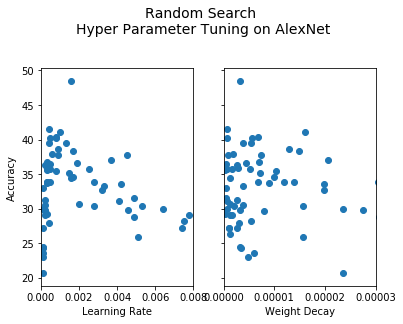

In [199]:
fig,(ax1,ax2)=plt.subplots(1,2, sharey=True)
ax2.scatter(train_losses_hyp['Weight_Decay'],train_losses_hyp['accuracy'])
ax2.set_xlim([0,.00003])
ax2.set_xlabel('Weight Decay')

ax1.scatter(train_losses_hyp['Learning_Rate'],train_losses_hyp['accuracy'])
ax1.set_xlim([0,.008])
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Accuracy')
fig.text(0.5, 1,'Random Search \nHyper Parameter Tuning on AlexNet',ha='center', fontsize=14)
plt.show()

# Run the Model with Hyper Parameters

In [207]:
lr = 0.0016
w= 3.2915e-06
optimize = 'Adam'
train_losses = []
acc_data_train = []

alex_net = models.alexnet(pretrained=True)
for param in alex_net.parameters():
    param.requires_grad = False
alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#Adjust Output
alex_net.classifier._modules['6'] = nn.Linear(4096, 7)

optimizer = optim.Adam(alex_net.parameters(),lr=lr, weight_decay = w, amsgrad=True)
criterion = nn.CrossEntropyLoss()


In [217]:
for epoch in range(1,5):
    alex_train(epoch,200,lr,w,optimize,train_losses, acc_data_train)

Train Epoch:1  Accuracy: (18010/20000) 90.05%   Average Loss: 0.30 

Train Epoch:2  Accuracy: (18057/20000) 90.28%   Average Loss: 0.30 

Train Epoch:3  Accuracy: (18135/20000) 90.67%   Average Loss: 0.28 

Train Epoch:4  Accuracy: (18221/20000) 91.11%   Average Loss: 0.26 



In [218]:
PATH = '/Users/JosephVele/Documents/gradschool_year2/ds5500/bodypart_model.pth'
torch.save(alex_net.state_dict(), PATH)

Number of Model Parameters:  57017031


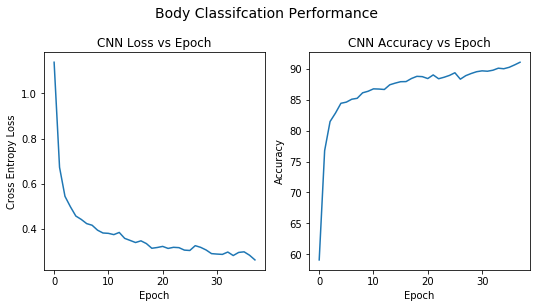

In [222]:
#************************************#
total_params = sum(p.numel() for p in alex_net.parameters())
print('Number of Model Parameters: ', total_params)
#************************************#
train_losses_pd = pd.DataFrame(train_losses, columns=['Optimizer', 'Learning_Rate', 'Weight_Decay', 'Average_Loss'])
body_losses = train_losses_pd['Average_Loss']
body_accuracy = acc_data_train

# 5.2 Summarize history for loss and make loss vs.epoch plot
#************************************#
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(body_losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross Entropy Loss')
ax1.set_title('CNN Loss vs Epoch')
ax2.plot(body_accuracy)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.subplots_adjust(right=1.25)
ax2.set_title('CNN Accuracy vs Epoch')

fig.text(0.64, 1,'Body Classifcation Performance',ha='center', fontsize=14)

plt.show()

In [223]:
test_losses = []
acc_data_test=[]

def alex_test(epoch):
    #Have our model in evaluation mode
    alex_net.eval()
    #Set losses and Correct labels to zero
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, sample_batched in enumerate(MuraTestLoader,1):

            inputs = sample_batched['image']
            labels = sample_batched['labels']

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = alex_net(inputs)
            loss = criterion(F.log_softmax(outputs, dim=1), labels)
            test_loss+= loss.item()
            pred = outputs.data.max(1, keepdim=True)[1].int()
            #print(pred)
            labels = labels.int()
            #print(labels)

            correct += pred.eq(labels.data.view_as(pred)).sum()
             
    
        accuracy = float(100*float(correct)/(len(MuraTestLoader.dataset)))

        acc_data_test.append([accuracy])
        test_loss=float(test_loss)/float(i)
        test_losses.append(test_loss)
        # print statistics        
        print('Test Epoch:{}  Accuracy: ({}/{}) {:.2f}%   Average Loss: {:.2f} \n'.
              format(epoch, correct,len(MuraTestLoader.dataset), accuracy, test_loss))

In [224]:
alex_test(1)

Test Epoch:1  Accuracy: (2893/3196) 90.52%   Average Loss: 0.31 



# Grad-CAM Using Trained Model

In [326]:
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np
import argparse

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            #print(x)
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
                
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """
    def __init__(self, model, target_layers):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output  = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        output = self.model.classifier(output)
        return target_activations, output

def preprocess_image(img):
    means=[0.456]
    stds=[0.225]
    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(1):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img.copy())
    preprocessed_img.unsqueeze_(0)
    input = Variable(preprocessed_img, requires_grad = True)
    return input

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))

class GradCam:
    def __init__(self, model, target_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, target_layer_names)


    def forward(self, input):
        return self.model(input) 


    def __call__(self, input, index = None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)


        if index == None:
            index = np.argmax(output.cpu().data.numpy())


        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1

        one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)

        else:
            one_hot = torch.sum(one_hot * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)
        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        
        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis = (2, 3))[0, :]
        cam = np.zeros(target.shape[1 : ], dtype = np.float32)


        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (227, 227))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam



In [327]:
import copy
alex_net_grad = copy.deepcopy(alex_net)
grad_cam = GradCam(model = alex_net_grad,target_layer_names = ["11"], use_cuda=False)

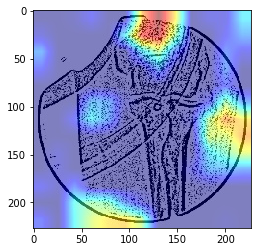

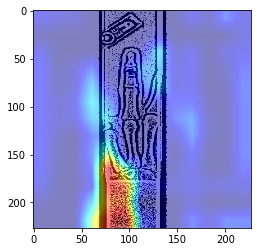

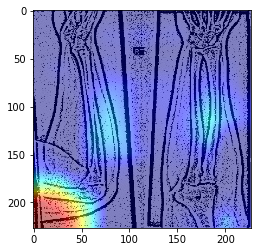

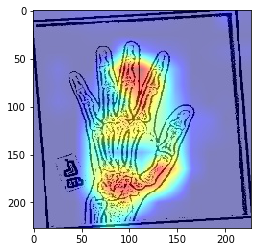

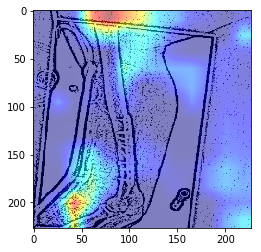

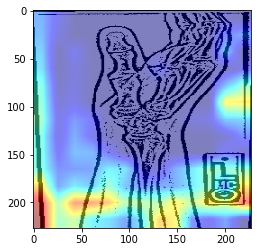

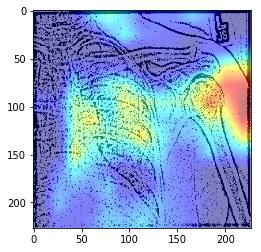

In [328]:
path = ['MURA-v1.1/train/XR_ELBOW/patient04903/study1_positive/image1.png',
        'MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image2.png',
        'MURA-v1.1/train/XR_FOREARM/patient09089/study2_negative/image1.png',
        'MURA-v1.1/train/XR_HAND/patient09740/study2_negative/image1.png',
        'MURA-v1.1/train/XR_HUMERUS/patient02697/study1_positive/image2.png',
        'MURA-v1.1/train/XR_WRIST/patient06364/study1_positive/image2.png',
        'MURA-v1.1/train/XR_SHOULDER/patient00007/study1_positive/image2.png']
for i in path:
    img = cv2.imread(i, 0)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2) 
    img = np.float32(cv2.resize(img, (227, 227))) / 255
    img = np.reshape(img,(227,227,1))
    input = preprocess_image(img)

    # If None, returns the map for the highest scoring category.

    # Otherwise, targets the requested index.
    target_index = None
    mask = grad_cam(input, target_index)
    show_cam_on_image(img, mask)
    result = cv2.imread('/Users/JosephVele/cam.jpg',1)
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    plt.imshow(result)
    plt.show()

In [154]:
gb_model = GuidedBackpropReLUModel(model = alex_net_grad, use_cuda=False)
gb = gb_model(input, index=target_index)
utils.save_image(torch.from_numpy(gb), 'gb.jpg')

cam_mask = np.zeros(gb.shape)
for i in range(0, gb.shape[0]):
    cam_mask[i, :, :] = mask

cam_gb = np.multiply(cam_mask, gb)
utils.save_image(torch.from_numpy(cam_gb), 'cam_gb.jpg')

In [123]:
#Hyperparameter tuning - Grid Search 
learning_rates = [.1,.01,.001, .00001]
momentums = [.3,.4,.5,.6, .7, .8, .9]
w = [.1,.01,.001]



for i in [1,2]: #Test different optimizer
    for j in range(len(learning_rates)):    
        if i ==1:
            for k in range(len(momentums)):
                #Reset Model per test
                alex_net = models.alexnet(pretrained=True)
                for param in alex_net.parameters():
                    param.requires_grad = False
                alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
                #Adjust Output
                alex_net.classifier._modules['6'] = nn.Linear(4096, 7)
                
                optimizer = optim.SGD(alex_net.parameters(), 
                                  lr=learning_rates[j], momentum=momentums[k])
                criterion = nn.CrossEntropyLoss()
                
                print('Optimizer: SGD\tLearning Rate: {}\tMomentum: {}'.
                      format (learning_rates[j], momentums[k]))
                alex_train(1,10)
                
        else: 
            for k in range(len(w)):
                #Reset Model per test
                alex_net = models.alexnet(pretrained=True)
                for param in alex_net.parameters():
                    param.requires_grad = False
                    
                alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
                #Adjust Output
                alex_net.classifier._modules['6'] = nn.Linear(4096, 7)
                
                optimizer = optim.Adam(alex_net.parameters(), 
                                       lr=learning_rates[j], weight_decay = w[k], amsgrad=True)
                criterion = nn.CrossEntropyLoss()
        
                print('Optimizer: Adam\t Learning Rate: {}\t WeightDecay: {}'.
                      format (learning_rates[j], w[k]))
                alex_train(1,10)

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.3
Train Epoch:7  Accuracy: (393/2000) 19.65%   Average Loss: 28.09 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.4
Train Epoch:7  Accuracy: (391/2000) 19.55%   Average Loss: 10790.84 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.5
Train Epoch:7  Accuracy: (364/2000) 18.20%   Average Loss: 17635.25 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.6
Train Epoch:7  Accuracy: (373/2000) 18.65%   Average Loss: 11194.87 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.7
Train Epoch:7  Accuracy: (366/2000) 18.30%   Average Loss: 6271.56 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.8
Train Epoch:7  Accuracy: (391/2000) 19.55%   Average Loss: 69021.08 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.9
Train Epoch:7  Accuracy: (327/2000) 16.35%   Average Loss: 1736027.30 

Optimizer: SGD	Learning Rate: 0.01	Momentum: 0.3
Train Epoch:7  Accuracy: (675/2000) 33.75%   Average Loss: 1.59 

Optimizer: SGD	Learning Rate: 0.01	Momentum: 0.4
Train Epoch: